In [1]:
import os
os.environ['THEANO_FLAGS'] = 'device=gpu, floatX=float32'

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cPickle as pickle
import scipy.io
import time
import ssn
import ks_test

from theano import *
import theano.tensor as T

%matplotlib inline

Using gpu device 0: GeForce GTX 680


In [3]:
# define symbolic variables for theano
dt = T.scalar('dt', dtype='float32')
c = T.scalar("c", dtype='float32')
h = T.matrix("h", dtype='float32')
n_E = T.matrix("n_E", dtype='float32')
n_I = T.matrix("n_I", dtype='float32')
W_EE = T.tensor3("W_EE", dtype='float32')
W_EI = T.tensor3("W_EI", dtype='float32')
W_IE = T.tensor3("W_IE", dtype='float32')
W_II = T.tensor3("W_II", dtype='float32')
k = T.matrix("k", dtype='float32')
tau_E = T.matrix("tau_E", dtype='float32')
tau_I = T.matrix("tau_I", dtype='float32')

I_E = T.matrix('I_E', dtype='float32')
I_I = T.matrix('I_I', dtype='float32')

I_thresh_E = T.matrix('I_thresh_E', dtype='float32')
I_thresh_I = T.matrix('I_thresh_I', dtype='float32')

r_SS_E = T.matrix('r_SS_E', dtype='float32')
r_SS_I = T.matrix('r_SS_I', dtype='float32')

r_e = T.matrix("r_e", dtype='float32')
r_i = T.matrix("r_i", dtype='float32')

# initial firing rates are all zero
r_E = theano.shared(np.zeros((75,75), dtype='float32'))
r_I = theano.shared(np.zeros((75,75), dtype='float32'))

# Compile functions:
I_E = c*h + T.sum(T.sum(W_EE*r_e,1),1).reshape((75,75)).T - T.sum(T.sum(W_EI*r_i,1),1).reshape((75,75)).T
I_I = c*h + T.sum(T.sum(W_IE*r_e,1),1).reshape((75,75)).T - T.sum(T.sum(W_II*r_i,1),1).reshape((75,75)).T

I_thresh_E = T.switch(T.lt(I_E,0), 0, I_E)
I_thresh_I = T.switch(T.lt(I_I,0), 0, I_I)

r_SS_E = k*T.pow(I_thresh_E, n_E)
r_SS_I = k*T.pow(I_thresh_I, n_I)

euler_E = r_e + dt*(-r_e+r_SS_E)/tau_E
euler_I = r_i + dt*(-r_i+r_SS_I)/tau_I

euler = theano.function(inputs=[dt,c,h,W_EE,W_EI,W_IE,W_II,n_E,n_I,k,tau_E,tau_I], 
                            outputs=[r_E, r_I],
                            givens={r_e:r_E, r_i:r_I},
                            updates=[(r_E,euler_E), (r_I,euler_I)],
                            allow_input_downcast=True)

In [4]:
# load Blasdel orientation and ocular dominance maps (previously processed,
# see map_analysis.ipynb
st = time.time()
# [OD_map_full, OP_map_full] = np.load('saved_vars/maps-Nov-7.p', 'rb')
[OD_map_full, OP_map_full] = np.load('saved_vars/maps-Nov-13.p', 'rb')
print "Elapsed time to load maps: %d seconds" % (time.time() - st)

# plt.figure()
# plt.imshow(OD_map_full)
# plt.colorbar()
# plt.title('Full ocular dominance map, Obermayer and Blasdel')

# plt.figure()
# plt.imshow(OP_map_full)
# plt.colorbar()
# plt.title('Full orientation map, Obermayer and Blasdel')

OD_map = OD_map_full[-75:,-75:]
OP_map = np.floor(OP_map_full[-75:,-75:])

Elapsed time to load maps: 0 seconds


In [5]:
n_units = 200
selected_units = np.floor( 75*np.random.rand(n_units, 2) )

OD_prefs = np.zeros(len(selected_units))
for i in range(len(selected_units)):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    OD_prefs[i] = OD_map[yi,xi]

In [6]:
start_time = time.time()
# Generate SSN with specified hyperparams:
ss_net = ssn.SSNetwork(ori_map=OP_map, ocd_map=OD_map)

c0 = 40
dt0 = 0.005
timesteps = 100
dx = ss_net.dx
N_pairs = ss_net.N_pairs

# Cast SSN variables to float32 for Theano:
W_EE0 = ss_net.W_EE.astype('float32')
W_EI0 = ss_net.W_EI.astype('float32')
W_IE0 = ss_net.W_IE.astype('float32')
W_II0 = ss_net.W_II.astype('float32')

k0 = ss_net.k.astype('float32')
n_E0 = ss_net.n_E.astype('float32')
n_I0 = ss_net.n_I.astype('float32')

tau_E0 = ss_net.tau_E.astype('float32')
tau_I0 = ss_net.tau_I.astype('float32')

# probe the monocular size tuning for the selected units and # find the SFS for each unit:
dom_sfs_E = np.zeros(n_units)
dom_sfs_I = np.copy(dom_sfs_E)
sfs_fr_E = np.zeros(n_units)
sfs_fr_I = np.copy(sfs_fr_E)
stim_sizes = np.linspace(0.5,5,10)
surround_outer_d = 10
dom_size_tuning_results = np.zeros((n_units, len(stim_sizes)+1, 2))

for i in range(n_units):
    sfs_found_E = False
    sfs_found_I = False
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    ori = OP_map[yi,xi]
    ocularity = np.round(OD_prefs[i])
    for j in range(len(stim_sizes)):
        h0 = ssn.generate_ext_stimulus( ori, stim_sizes[j], [dx*xi, dx*yi], OP_map, OD_map, ocularity)
        for t in range(timesteps):
            euler(dt0,c0,h0,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)

        dom_size_tuning_results[i,j,0] = r_E.get_value()[yi,xi]
        dom_size_tuning_results[i,j,1] = r_I.get_value()[yi,xi] 
        r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))

        # check to see if any of the rates overflowed:
        if dom_size_tuning_results[i,j,0]>1000 or np.isnan(dom_size_tuning_results[i,j,0]):
            print "Network unstable, skipping!"
            
        if dom_size_tuning_results[i,j,0] > sfs_fr_E[i]:
            sfs_fr_E[i] = dom_size_tuning_results[i,j,0]
            dom_sfs_E[i] = stim_sizes[j]
        else:
            sfs_found_E = True

        if dom_size_tuning_results[i,j,1] > sfs_fr_I[i]:
            sfs_fr_I[i] = dom_size_tuning_results[i,j,1]
            dom_sfs_I[i] = stim_sizes[j]
        else:
            sfs_found_I = True

        if sfs_found_E and sfs_found_I:
            break

# probe the dominant eye surround suppression:
for i in range(n_units):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    ori = OP_map[yi,xi]
    ocularity = np.round(OD_prefs[i])
    h0 = ssn.generate_ext_stimulus( ori, surround_outer_d, [dx*xi, dx*yi], OP_map, OD_map, ocularity)
    for t in range(timesteps):
        euler(dt0,c0,h0,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)

    dom_size_tuning_results[i,-1,0] = r_E.get_value()[yi,xi]
    dom_size_tuning_results[i,-1,1] = r_I.get_value()[yi,xi] 
    r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
    r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))

# Now probe the non dominant stimuli (surround only)
non_dom_surround_results = np.zeros((n_units, 2))
for i in range(n_units):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    ori = OP_map[yi,xi]
    dom_ocu = np.round(OD_prefs[i])
    nd_ocu = np.abs(dom_ocu-1)
    centre = ssn.generate_ext_stimulus( ori, dom_sfs_E[i], [dx*xi, dx*yi], OP_map, OD_map, dom_ocu )
    surround = ssn.generate_ring_stimulus( ori, dom_sfs_E[i], surround_outer_d, [dx*xi, dx*yi], nd_ocu, OP_map, OD_map)
    h0 = centre + surround
    for t in range(timesteps):
        euler(dt0,c0,h0,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)

    non_dom_surround_results[i,0] = r_E.get_value()[yi,xi]
    if dom_sfs_E[i]==dom_sfs_I[i]:
        non_dom_surround_results[i,1] = r_I.get_value()[yi,xi] 
    else:
        r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        centre = ssn.generate_ext_stimulus( ori, dom_sfs_I[i], [dx*xi, dx*yi], OP_map, OD_map, dom_ocu )
        surround = ssn.generate_ring_stimulus( ori, dom_sfs_I[i], surround_outer_d, [dx*xi, dx*yi], nd_ocu, OP_map, OD_map)
        h0 = centre + surround    
        for t in range(timesteps):
            euler(dt0,c0,h0,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)  
        non_dom_surround_results[i,1] = r_I.get_value()[yi,xi]

    r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
    r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))

dom_SI_E = (sfs_fr_E - dom_size_tuning_results[:,-1,0])/sfs_fr_E
non_dom_SI_E = (sfs_fr_E - non_dom_surround_results[:,0])/sfs_fr_E
dom_SI_I = (sfs_fr_I - dom_size_tuning_results[:,-1,1])/sfs_fr_I
non_dom_SI_I = (sfs_fr_I - non_dom_surround_results[:,1])/sfs_fr_I                          

# Concatenate the E and I results
model_data_x = np.concatenate((dom_SI_E, dom_SI_I))
model_data_y = np.concatenate((non_dom_SI_E, non_dom_SI_I))

deangelis_data = np.array([[42.711, 21.488],
                        [44.588, 24.483],
                        [44.999, 31.508],
                        [58.885, 42.252],
                        [56.048, 57.955],
                        [64.901, 85.434],
                        [75.685, 65.186],
                        [79.023, 70.455],
                        [84.173, 42.045],
                        [98.365, 60.537],
                        [98.224, 95.248],
                        [82.045, 78.616],
                        [81.002, 76.550]])
deangelis_data = deangelis_data/100

d, prob = ks_test.ks2d2s(deangelis_data[:,0], deangelis_data[:,1], model_data_x, model_data_y)

print "P-value: ", prob
print "Elapsed time: %d seconds" %(time.time()-start_time)

Running a 2D, 2 sample Kolmogorov-Smirnov test!
P-value:  0.000188398826562
Elapsed time: 14121 seconds


In [7]:
# run full-size gratings to find SSI:
ff_results = np.zeros((n_units, 2))
for i in range(n_units):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    ori = OP_map[yi,xi]
    h0 = ssn.generate_mono_stimulus( ori, 16., [dx*xi, dx*yi], OP_map )
    for t in range(timesteps):
        euler(dt0,c0,h0,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)

    ff_results[i,0] = r_E.get_value()[yi,xi]
    ff_results[i,1] = r_I.get_value()[yi,xi] 
    r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
    r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))

In [8]:
SSI_E = (sfs_fr_E - ff_results[:,0] ) / sfs_fr_E
SSI_inds_E = np.where( SSI_E > 0.25 )

SSI_I = (sfs_fr_I - ff_results[:,1] ) / sfs_fr_I
SSI_inds_I = np.where( SSI_I > 0.25 )

In [13]:
print "E units showing strong surround suppresson: %d of %d" % (len(SSI_inds_E[0]), len(SSI_E))
print "I units showing strong surround suppresson: %d of %d" % (len(SSI_inds_I[0]), len(SSI_I))

E units showing strong surround suppresson: 180 of 200
I units showing strong surround suppresson: 56 of 200


Running a 2D, 2 sample Kolmogorov-Smirnov test!
P-value:  0.00518398667664


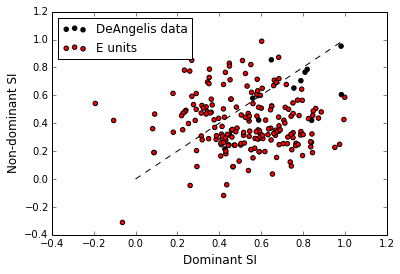

In [15]:
plt.figure()
plt.scatter(deangelis_data[:,0], deangelis_data[:,1], c='k', label='DeAngelis data')
# plt.scatter(model_data_x, model_data_y, c='r')
plt.scatter(dom_SI_E, non_dom_SI_E, c='r', label='E units')
# plt.scatter(dom_SI_I, non_dom_SI_I, c='b')
plt.plot([0,1], [0,1], 'k--')
# plt.axis([0,1,0,1])
plt.xlabel('Dominant SI', fontsize=12)
plt.ylabel('Non-dominant SI', fontsize=12)
plt.legend(loc='best')

d, prob = ks_test.ks2d2s(deangelis_data[:,0], deangelis_data[:,1], dom_SI_E, non_dom_SI_E)
print "P-value: ", prob

# plt.savefig('thesis_results/ssn_iot_E.eps', dpi=1000)

Running a 2D, 2 sample Kolmogorov-Smirnov test!
P-value:  0.00640063626113


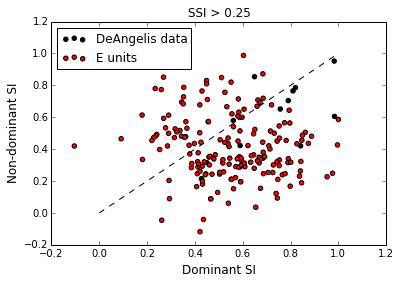

In [14]:
plt.figure()
plt.scatter(deangelis_data[:,0], deangelis_data[:,1], c='k', label='DeAngelis data')
# plt.scatter(model_data_x, model_data_y, c='r')
plt.scatter(dom_SI_E[SSI_inds_E], non_dom_SI_E[SSI_inds_E], c='r', label='E units')
# plt.scatter(dom_SI_I, non_dom_SI_I, c='b')
plt.plot([0,1], [0,1], 'k--')
# plt.axis([0,1,0,1])
plt.xlabel('Dominant SI', fontsize=12)
plt.ylabel('Non-dominant SI', fontsize=12)
plt.title('SSI > 0.25')
plt.legend(loc='best')

d, prob = ks_test.ks2d2s(deangelis_data[:,0], deangelis_data[:,1], dom_SI_E[SSI_inds_E], non_dom_SI_E[SSI_inds_E])
print "P-value: ", prob

# plt.savefig('thesis_results/ssn_iot_E_SSI.eps', dpi=1000)

Running a 2D, 2 sample Kolmogorov-Smirnov test!
P-value:  1.87210841876e-08


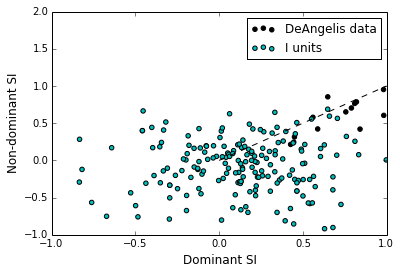

In [11]:
plt.figure()
plt.scatter(deangelis_data[:,0], deangelis_data[:,1], c='k', label='DeAngelis data')
# plt.scatter(model_data_x, model_data_y, c='r')
#plt.scatter(dom_SI_E, non_dom_SI_E, c='r', label='E units')
plt.scatter(dom_SI_I, non_dom_SI_I, c='c', label='I units')
plt.plot([0,1], [0,1], 'k--')
plt.axis([-1,1,-1,2])
plt.xlabel('Dominant SI', fontsize=12)
plt.ylabel('Non-dominant SI', fontsize=12)
plt.legend(loc='best')

d, prob = ks_test.ks2d2s(deangelis_data[:,0], deangelis_data[:,1], dom_SI_I, non_dom_SI_I)
print "P-value: ", prob

plt.savefig('thesis_results/ssn_iot_I.eps', dpi=1000)

Running a 2D, 2 sample Kolmogorov-Smirnov test!
P-value:  3.31162212942e-06


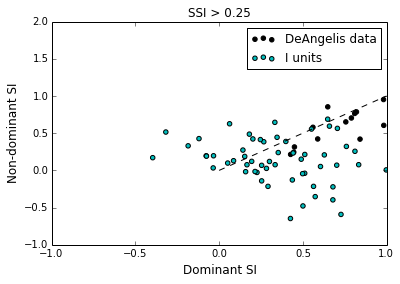

In [12]:
plt.figure()
plt.scatter(deangelis_data[:,0], deangelis_data[:,1], c='k', label='DeAngelis data')
# plt.scatter(model_data_x, model_data_y, c='r')
#plt.scatter(dom_SI_E, non_dom_SI_E, c='r', label='E units')
plt.scatter(dom_SI_I[SSI_inds_I], non_dom_SI_I[SSI_inds_I], c='c', label='I units')
plt.plot([0,1], [0,1], 'k--')
plt.axis([-1,1,-1,2])
plt.xlabel('Dominant SI', fontsize=12)
plt.ylabel('Non-dominant SI', fontsize=12)
plt.title('SSI > 0.25')
plt.legend(loc='best')

d, prob = ks_test.ks2d2s(deangelis_data[:,0], deangelis_data[:,1], dom_SI_I[SSI_inds_I], non_dom_SI_I[SSI_inds_I])
print "P-value: ", prob

plt.savefig('thesis_results/ssn_iot_I_SSI.eps', dpi=1000)

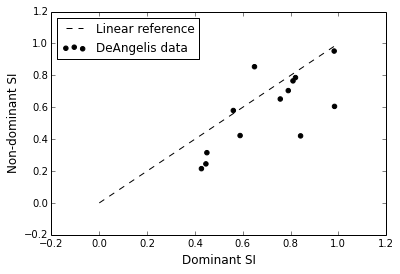

In [16]:
plt.figure()
plt.scatter(deangelis_data[:,0], deangelis_data[:,1], c='k', label='DeAngelis data')
plt.plot([0,1], [0,1], 'k--', label='Linear reference')
#plt.axis([-1,1,-1,2])
plt.xlabel('Dominant SI', fontsize=12)
plt.ylabel('Non-dominant SI', fontsize=12)
plt.legend(loc='best')

plt.savefig('thesis_results/deangelis_iot_data.eps', dpi=1000)